# EIT-CEM Quick Start

In [34]:
#Fix your enviroment
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from codes.module1_mesh import *
from codes.module2_forward import *
from codes.module3_inverse import *
from codes.module4_auxiliar import *
%matplotlib inline

In [35]:
"Basic Definitions"
r=1            #Circle radius
L=16           #Number of Electrodes
per_cober=0.5  #Percentage of area covered by electrodes
rotate=0       #Rotation

#Return object with angular position of each electrode
ele_pos=electrodes_position(L, per_cober, rotate)

In [36]:
refine_n=8 #Refinement mesh
n_in=8     #Vertex on elec.
n_out=2    #Vertex on gaps (Sometimes it is important.)

#Generating Mesh
mesh=MyMesh(r=r, n=refine_n, n_in=n_in, n_out=n_out, electrodes_obj=ele_pos)
mesh_refined=MyMesh(r=r, n=refine_n*3, n_in=n_in*3, n_out=n_out*3, electrodes_obj=ele_pos)

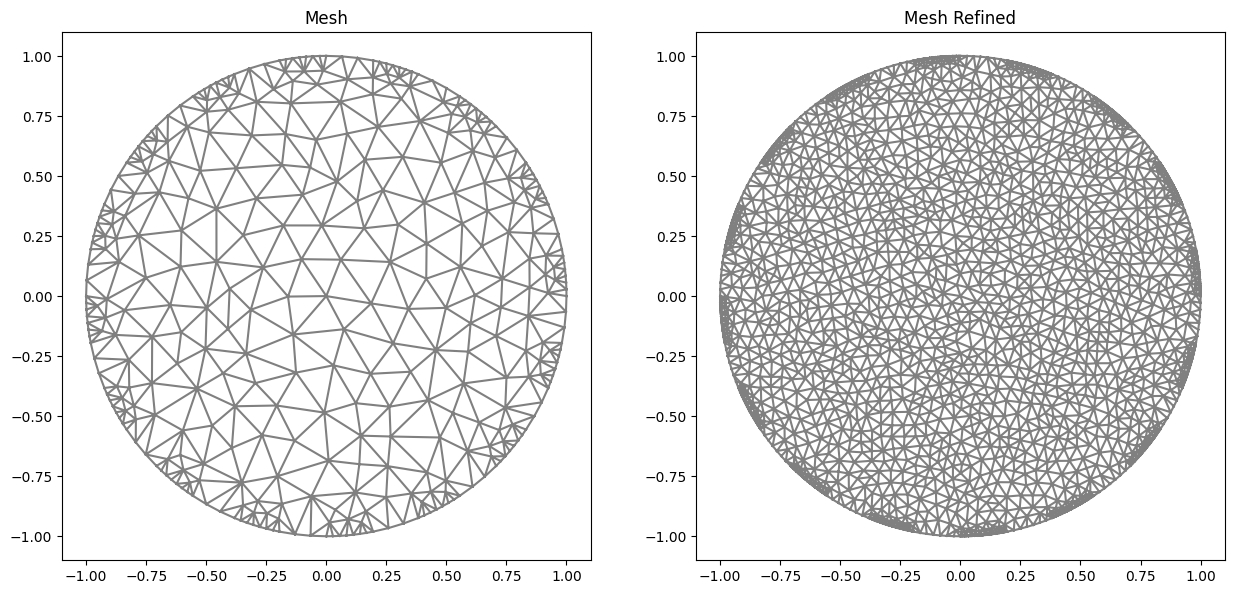

In [52]:
plt.figure(figsize=(15, 15))
plt.subplot(1,2,2)
plot(mesh_refined, title="Mesh Refined");
plt.subplot(1,2,1)
plot(mesh, title="Mesh");
plt.savefig("quick/mesh.png", bbox_inches='tight', transparent=True)

## Simulating Data

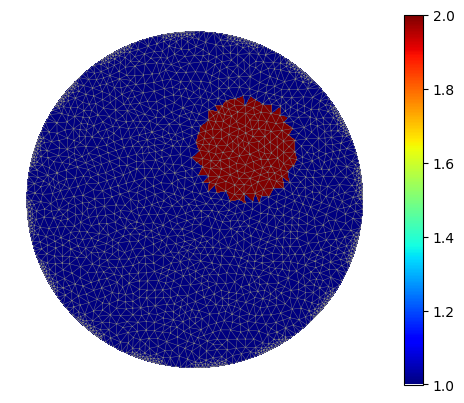

In [53]:
#Defining the function gamma in Descontinuous Galerkin
ValuesCells0=GammaCircle(mesh_refined,2,1.0,0.3, 0.3, 0.3); #mesh, cond_in, cond_out, radius, certerx, cerntery
Q = FunctionSpace(mesh_refined, "DG", 0) #Define Function space with basis Descontinuous Galerkin
gamma = Function(Q)
gamma.vector()[:]=ValuesCells0


"Plot"
plot_figure(gamma, name="", map="jet");
plot(mesh_refined, linewidth=0.3)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.savefig("quick/gamma.png", bbox_inches='tight', transparent=True)

### Forward Problem

In [39]:
#Defining impedances, experiments and currents
z=np.ones(L)*2.5E-5     #Impedance of each electrode
l=L-1                   #Numero of experiments
I_all=current_method( L , l, method=2)  #Current

In [54]:
print(np.array(I_all))

[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 

In [42]:
ForwardObject=ForwardProblem(mesh_refined, z)

VD=FiniteElement('CG',mesh_refined.ufl_cell(),1) #Solution Space Continous Galerkin
list_u,list_U0 = ForwardObject.solve_forward(VD, I_all, gamma)
list_U0 = (np.array(list_U0).flatten())


In [43]:
print(list_U0[0:L])

[ 0.59683392 -0.58225101 -0.1770248  -0.09720831 -0.06548889 -0.04681257
 -0.03301847 -0.02162958 -0.01117799 -0.00067388  0.01052077  0.02352289
  0.04025457  0.06430932  0.10463569  0.19520837]


### Plot u

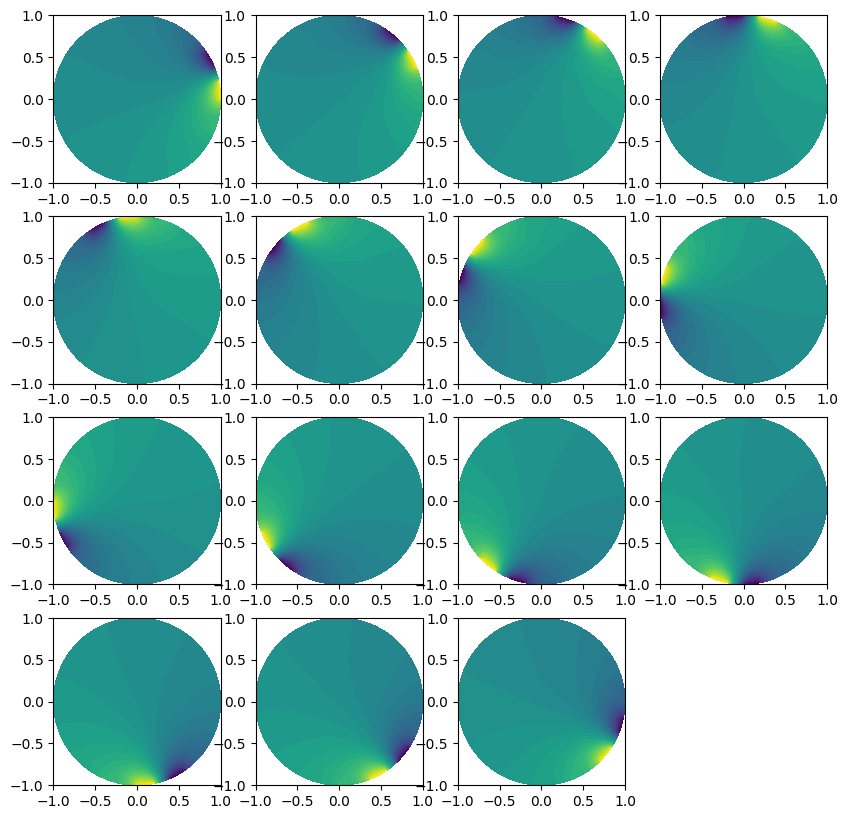

In [45]:
plt.figure(figsize=(10, 10))
for i in range(0, l):
    plt.subplot(4,4,i+1)
    plot(list_u[i])


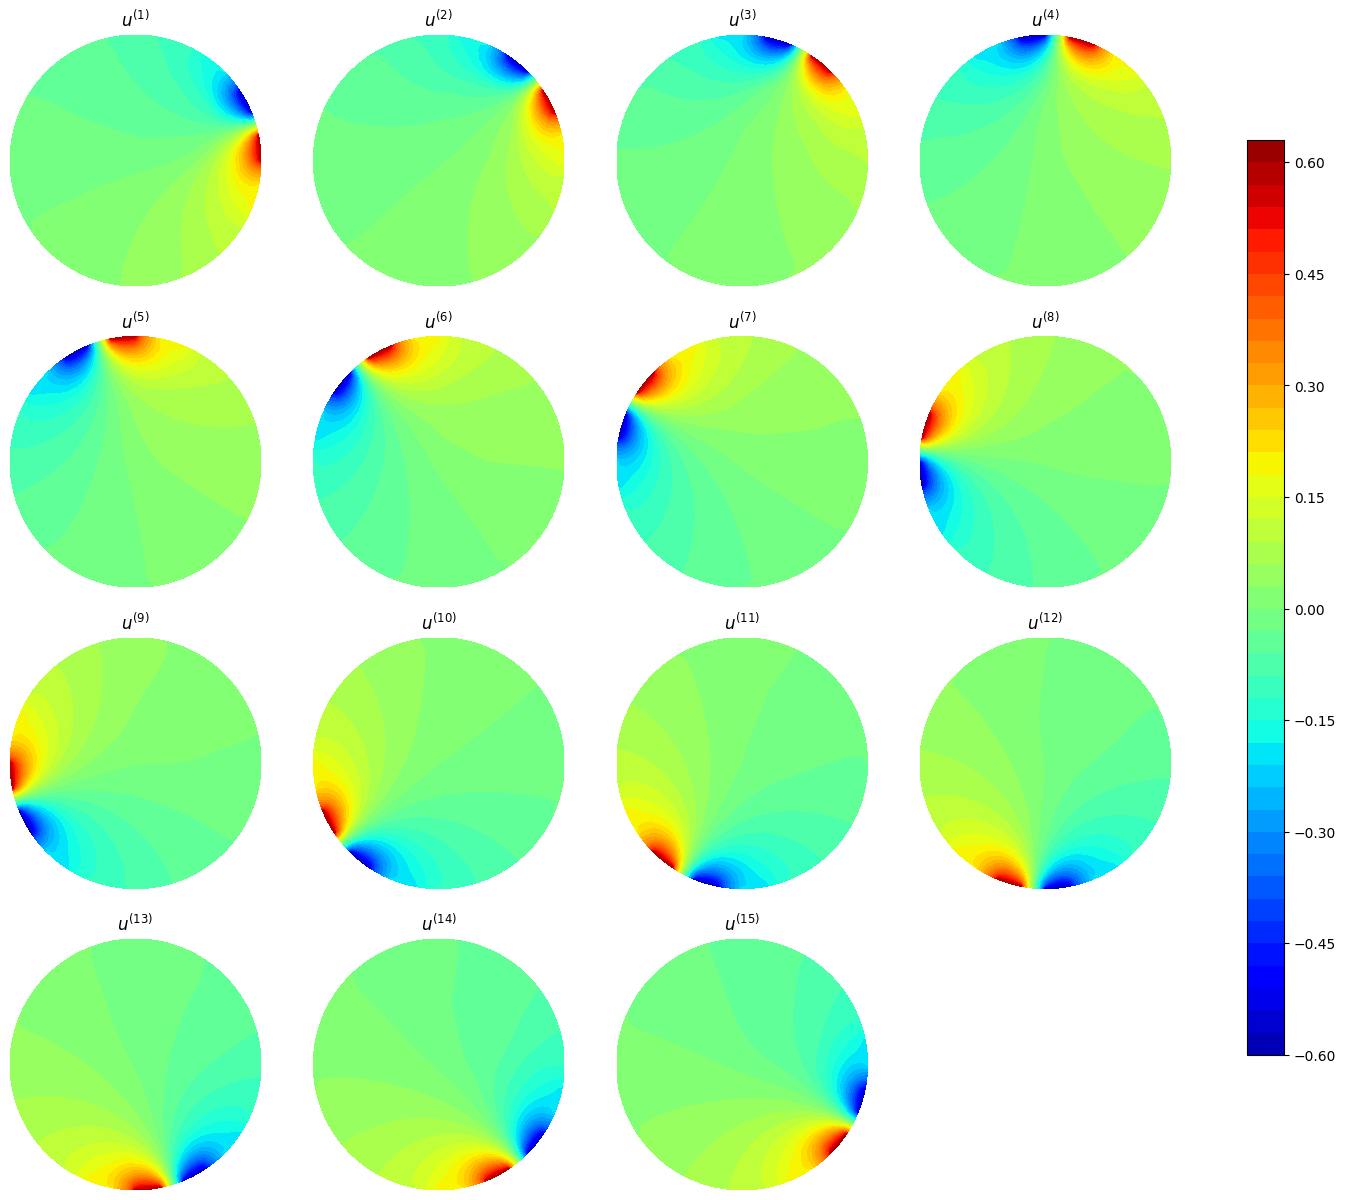

In [56]:
fig = plt.figure(figsize=(15,15))
for i,u in enumerate(list_u,1):
    plt.subplot(4,4,i)
    p = plot(u, title=f'$u^{{({i})}}$')
    p.set_cmap("jet")
    p.set_clim(-0.65,0.65)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
cbar_ax = fig.add_axes([0.95,0.2,0.025,0.61])
fig.colorbar(p, cax=cbar_ax, orientation="vertical")
plt.savefig("quick/potential.png", bbox_inches='tight', transparent=True)

### Solver

### Plot Noise

In [59]:
#Noise add
noise_level=0.25/100
noise_type='uniform'
list_U0_noised=fn_addnoise(list_U0, noise_level, noise_type, seed=42)

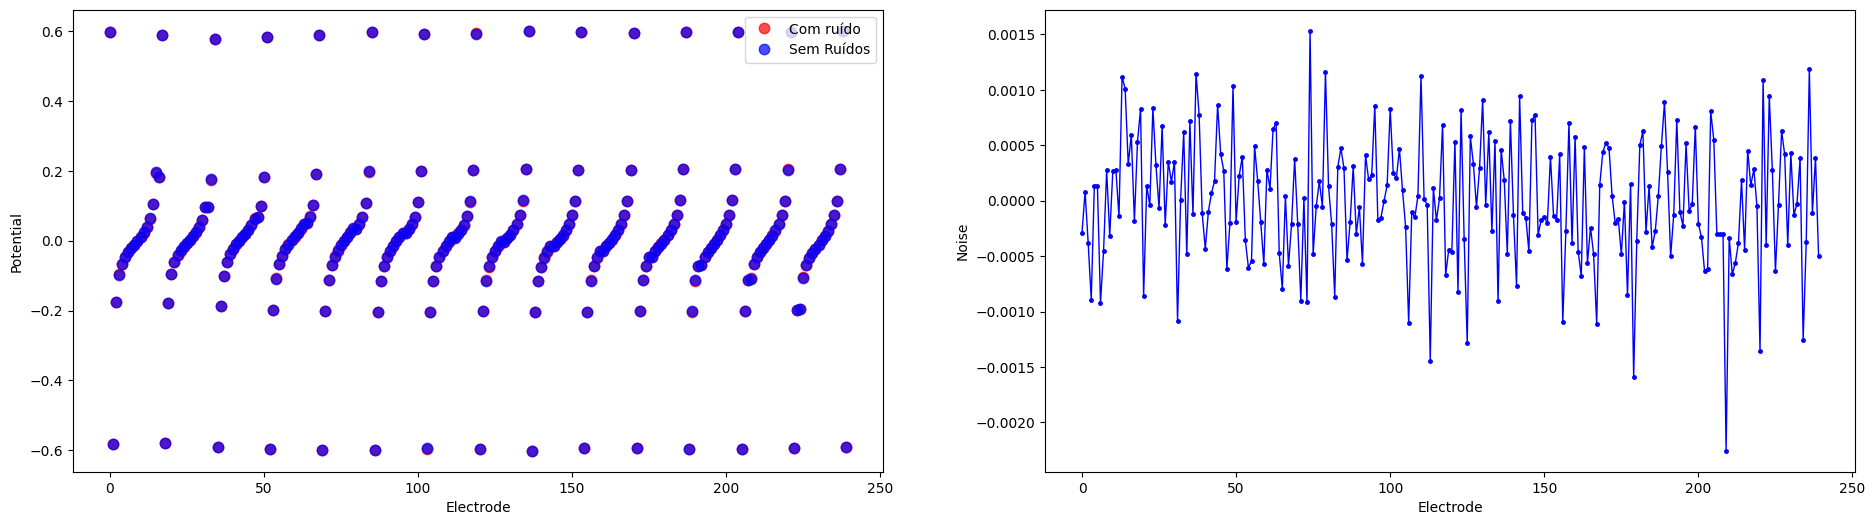

In [60]:
vec_U0_noise=list_U0_noised
vec_U0=list_U0
x=range(len(vec_U0_noise))

fig, ax = plt.subplots(1,2, figsize=(23,6))
ax[0].plot(x, vec_U0_noise, linewidth=0,  marker='.', markersize=15, label="Com ruído", color='red', alpha=0.7);
ax[0].plot(x, vec_U0, linewidth=0,  marker='.', markersize=15, label="Sem Ruídos", color="blue", alpha=0.7);
ax[0].set_xlabel("Electrode")
ax[0].set_ylabel("Potential")
ax[0].legend()

ax[1].plot(x, vec_U0-vec_U0_noise, linewidth=1,  marker='.', markersize=5, color="blue");
ax[1].set_xlabel("Electrode")
ax[1].set_ylabel("Noise")
plt.savefig("quick/noise.png", bbox_inches='tight', transparent=True)

### Solver parameters

In [69]:
"Object"
InverseObject=InverseProblem(mesh, list_U0_noised, I_all, z)

"Solver Parameters"
#InverseObject.set_InnerParameters(inner_method='Tikhonov', Tik_c0=0.001, Tik_q=1)
InverseObject.set_InnerParameters(inner_method='Landweber', land_a=20)
InverseObject.set_solverconfig(step_limit=100, verbose=True)
#InverseObject.set_NewtonParameters(mu_i=0.85, mumax=0.999, nu=0.97, R=0.97)


"First step"
gamma_background=np.ones(mesh.num_cells())
InverseObject.set_firstguess(gamma_background)

"Noise Parameters"
tau=1.05
InverseObject.set_NoiseParameters(tau, noise_level)
print(f"Discrepance stop {np.round(tau*noise_level*100,5)}% residue")

"Extra data"
InverseObject.set_answer(gamma, mesh_refined)

Discrepance stop 0.2625% residue


In [70]:
#Solver
InverseObject.solve_inverse()


*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 26.540399150834666 Residual (%): 9.909999090734685 step: 0 Inner step: 0
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 26.609658 Residual (%): 4.112211 step: 1 Inner step: 1 mu_n: 0.9
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 26.281973 Residual (%): 3.596244 step: 2 Inner step: 1 mu_n: 0.9
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 25.592949 Residual (%): 3.008053 step: 3 Inner step: 2 mu_n: 0.8991
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 25.317938 Residual (%): 2.780579 step: 4 Inner step: 1 mu_n: 0.9486
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%): 24.85363 Residual (%): 2.415526 step: 5 Inner step: 2 m

### Plot gamma_k

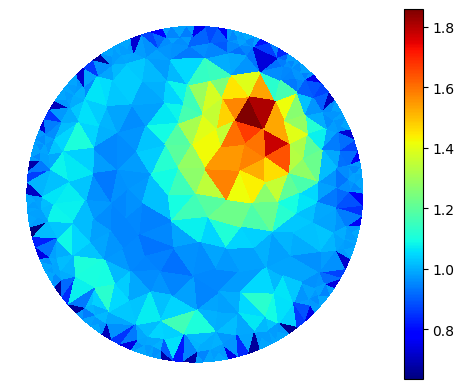

In [73]:
#Plot 2D
#Preparing Function
gamma_k=np.copy(InverseObject.gamma_all)[-1]    
Q_DG=FunctionSpace(mesh, "DG", 0)
gamma_cell = Function(Q_DG)
gamma_cell.vector()[:]=gamma_k          #Transform vector to function

#Plotting
plot_figure(gamma_cell, name="", map="jet");
plt.xticks([])
plt.yticks([])
plt.box(False)

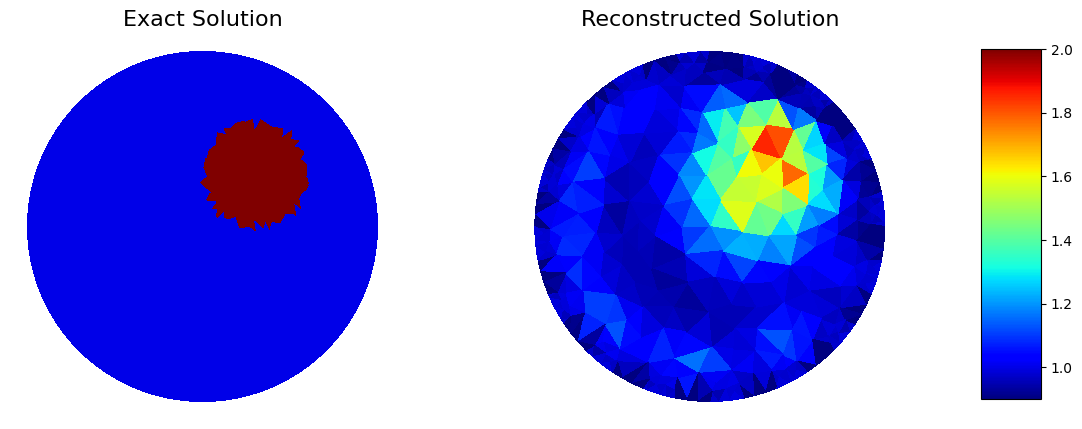

In [74]:
gamma_list=[gamma, gamma_cell]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i in range(0, len(gamma_list)):
    plt.subplot(1,2,i+1)
    p=plot(gamma_list[i])
    p.set_cmap('jet')    
    p.set_clim(0.90, 2)
    plt.xticks([])
    plt.yticks([])
    if i==0: plt.title("Exact Solution", fontsize=16)
    if i==1: plt.title("Reconstructed Solution", fontsize=16)
    plt.box(False)
        
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)
plt.savefig("quick/gamma_ans.png", bbox_inches='tight', transparent=True)